## Importing libraries

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive')

# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [145]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', index_col="day", usecols = ["day", "TS_actual", "VS_actual", "reactor1"])
# df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', usecols=[1])
df.sort_index(inplace=True)
df.head()

,TS_actual,VS_actual,reactor1
day,,,
0,369.5930,338.3879,0
1,357.2494,326.3529,100
2,344.9058,314.3179,120
3,332.5622,302.2829,100
4,320.2186,290.2479,100


## Scaling the data
The train-test split needs to be done in a sequential manner, and not randomly.

In [146]:
# Using the MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df)

scaled_dataset = scaler.transform(df)

## Generating sequences
To generate a series based input for our model.

In [147]:
def sequenceGenerator(dataset, sequenceSize=1):
  #Function that returns X and y from a given set of data points, where X is a set of sequences
    X = []
    y = []

    # using a sliding window to get values for the sequence. The value just after the sequnce is used as y
    for i in range(len(dataset)-sequenceSize-1):
        current_window = dataset[i:(i+sequenceSize), :]
        X.append(current_window)
        y.append(dataset[i+sequenceSize, -1])
        
    return np.array(X),np.array(y)

# Using the function to generate train and test sequences

# Defining the sequence size to be used.
sequence_size = 8
X, y = sequenceGenerator(scaled_dataset, sequence_size)
len(X)

112

## Splitting into train and test set
This needs to be done sequentially.

In [148]:
# Setting a fraction for train data
train_fraction = 0.7
train_size = (int)(len(X)*train_fraction)

# Splitting the train and test data
X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size :]
y_test = y[train_size :]

# Bootstrapping
We will take bootstrapped samples of the training and test data to train multiple models.

Then use a confidence interval from these models to predict a range of values for the predicted biogas

### Early Stopping
This is used to detect over fitting and stop further epochs. It is sent as a callback when the model is compiled

In [149]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=50,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [150]:
# Set the number of bootstrap iterations
n_bootstraps = 100

# Initialize arrays to store the predictions and true values
trained_models = []

# loop over the iterations
for i in range(n_bootstraps):

  print("Bootstrap:", i+1)
  train_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
  test_indices = np.random.choice(len(X_test), size=len(X_test), replace=True)

  # Build the bootstrap sample
  X_train_sample = X_train[train_indices]
  X_test_sample = X_test[test_indices]

  y_train_sample = y_train[train_indices]
  y_test_sample = y_test[test_indices]

  # Build and train the model

  model = Sequential()
  model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(20, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X_train_sample, y_train_sample, validation_data=(X_test_sample, y_test_sample), epochs=200, callbacks=callback, shuffle=False, verbose=0)

  # Adding the compiled model to the list of models
  trained_models.append(model)


Bootstrap: 1
Epoch 96: early stopping
Bootstrap: 2
Epoch 81: early stopping
Bootstrap: 3
Epoch 82: early stopping
Bootstrap: 4
Bootstrap: 5
Epoch 155: early stopping
Bootstrap: 6
Epoch 110: early stopping
Bootstrap: 7
Epoch 89: early stopping
Bootstrap: 8
Epoch 97: early stopping
Bootstrap: 9
Epoch 93: early stopping
Bootstrap: 10
Epoch 67: early stopping
Bootstrap: 11
Epoch 192: early stopping
Bootstrap: 12
Epoch 78: early stopping
Bootstrap: 13
Epoch 92: early stopping
Bootstrap: 14
Epoch 108: early stopping
Bootstrap: 15
Epoch 110: early stopping
Bootstrap: 16
Epoch 91: early stopping
Bootstrap: 17
Epoch 105: early stopping
Bootstrap: 18
Epoch 103: early stopping
Bootstrap: 19
Epoch 94: early stopping
Bootstrap: 20
Epoch 110: early stopping
Bootstrap: 21
Epoch 93: early stopping
Bootstrap: 22
Epoch 107: early stopping
Bootstrap: 23
Epoch 160: early stopping
Bootstrap: 24
Epoch 176: early stopping
Bootstrap: 25
Epoch 90: early stopping
Bootstrap: 26
Epoch 68: early stopping
Bootstrap

# Making predictions
Here we get the mean value and the confidence interval for the predictions.

In [151]:
# Calculate the mean and the confidence interval 
# confidence_interval = (pred_mean - 1.96 * pred_std, pred_mean + 1.96 * pred_std)

def make_predictions(X):
  pred_mean = []
  pred_conf_min = []
  pred_conf_max = []

  predictions = []
  for model in trained_models:
    # Each row is the output of one model. 
    predictions.append(model.predict(X))

  # Take transpose to calculate stats for each observation 
  predictions = np.transpose(predictions)[0]
  for i in range(len(predictions)):
    # Calculate stats
    current_mean = np.mean(predictions[i])
    current_std = np.std(predictions[i])

    pred_mean.append(current_mean)
    pred_conf_min.append(current_mean - 1.96*current_std) 
    pred_conf_max.append(current_mean + 1.96*current_std) 
  
  # Reshaping the final arrays
  pred_mean = np. reshape(np.array(pred_mean), (-1, 1))
  pred_conf_min = np. reshape(np.array(pred_conf_min), (-1, 1))
  pred_conf_max = np. reshape(np.array(pred_conf_max), (-1, 1))
  return pred_mean, pred_conf_min, pred_conf_max


# Plotting the train and test values

3/3 [==============================] - 1s 6ms/step


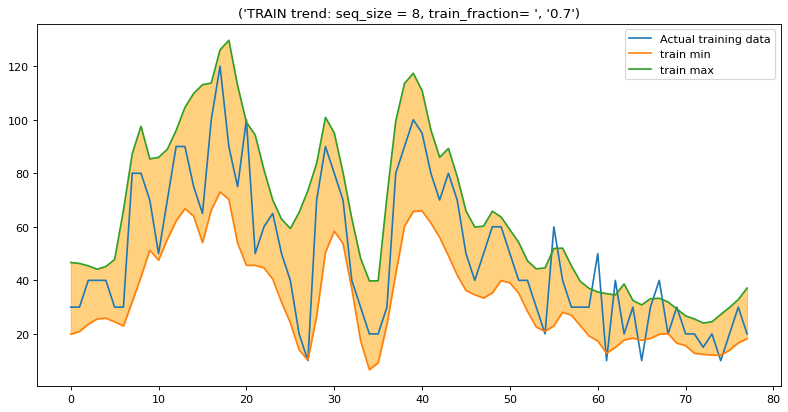

In [152]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train, train_min, train_max = make_predictions(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

train_min = np.repeat(train_min, scaled_dataset.shape[1], axis=-1)
train_max = np.repeat(train_max, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]
train_min_inv = scaler.inverse_transform(train_min)[:,-1]
train_max_inv = scaler.inverse_transform(train_max)[:,-1]

x = np.arange(len(actual_train))
# Plotting the result
figure(figsize=(12, 6), dpi=80)
# plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.plot(x, train_min_inv, label='train min')
plt.plot(x, train_max_inv, label='train max')
plt.fill_between(x, train_min_inv, train_max_inv, color='orange', alpha=0.5)
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 10ms/step


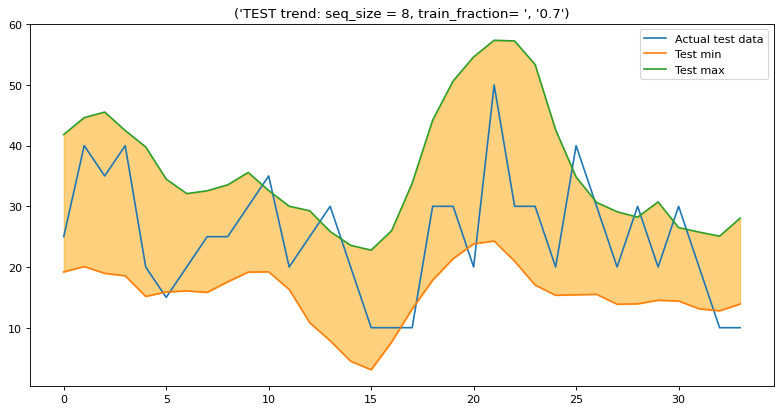

In [153]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test, test_min, test_max = make_predictions(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)
test_min = np.repeat(test_min, scaled_dataset.shape[1], axis=-1)
test_max = np.repeat(test_max, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]
test_min_inv = scaler.inverse_transform(test_min)[:,-1]
test_max_inv = scaler.inverse_transform(test_max)[:,-1]

x = np.arange(len(actual_test))
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(actual_test_inv, label='Actual test data')
# plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(x, test_min_inv, label='Test min')
plt.plot(x, test_max_inv, label='Test max')
plt.fill_between(x, test_min_inv, test_max_inv, color='orange', alpha=0.5)
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

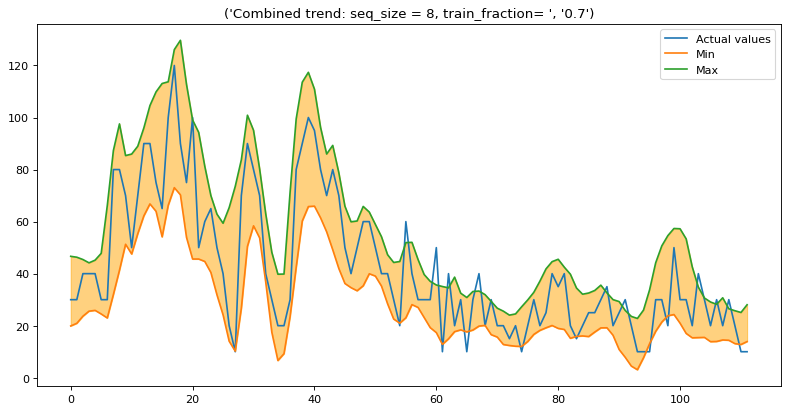

In [154]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])
combined_min =  np.vstack([train_min, test_min])
combined_max =  np.vstack([train_max, test_max])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
combined_min_inv = scaler.inverse_transform(combined_min)[:, -1]
combined_max_inv = scaler.inverse_transform(combined_max)[:, -1]

x = np.arange(len(actual_combined))
# Plotting the result
figure(figsize=(12, 6), dpi=80)
# plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.plot(x, combined_min_inv, label='Min')
plt.plot(x, combined_max_inv, label='Max')
plt.fill_between(x, combined_min_inv, combined_max_inv, color='orange', alpha=0.5)

plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [155]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.838 ,  0.287 ,  0.845


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [156]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  10.851 ,  8.159 ,  10.11
